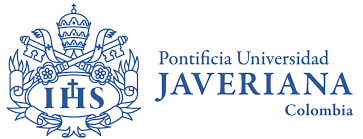

# Taller Spark MLlib – Procesamiento de Datos a Gran Escala

**Curso:** Computación de Alto Desempeño

**Estudiante:** Sebastian Fanchi

**Fecha:** 20/11/2025

## Descripción general

En este cuaderno buscamos aplicar ciertas tecnicas de preprocesamiento de datos aplicado a un conjunto de datos: **Titanic** (datos de pasajeros del famoso barco).  

Se trabajarán los siguientes temas usando PySpark y MLlib:

1. Carga y exploración del dataset  
2. Identificación y tratamiento de valores faltantes  
3. Agrupación y agregación  
4. Cuantiles y estadísticas descriptivas  
5. Tablas dinámicas (pivot)  
6. Transformación de estructuras anidadas (explode)  
7. Normalización y escalamiento de variables con Spark MLlib  
8. Resumen y conclusiones

In [14]:
# Inicialización de SparkSession conectada al clúster

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Taller_MLlib_Titanic")
    .master("spark://10.43.100.119:7077")
    .config("spark.submit.deployMode", "client")
    .config("spark.driver.bindAddress", "0.0.0.0")
    .config("spark.driver.host", "localhost")
    .getOrCreate()
)

## 1. Carga y exploración del conjunto de datos

Usaremos una versión del dataset **Titanic**, que contiene información de pasajeros:

- `Survived`: 0 = no sobrevivió, 1 = sobrevivió  
- `Pclass`: clase del ticket (1, 2, 3)  
- `Sex`: sexo del pasajero  
- `Age`: edad  
- `SibSp`: número de hermanos/cónyuges a bordo  
- `Parch`: número de padres/hijos a bordo  
- `Fare`: tarifa pagada  
- `Embarked`: puerto de embarque  

In [19]:
# Carga del dataset Titanic desde archivo CSV

from pyspark.sql import functions as F

data_path = "data/titanic.csv"

titanic_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(data_path)
)

# Exploración básica
titanic_raw.printSchema()
titanic_raw.show(5)
print("Número de filas:", titanic_raw.count())
print("Número de columnas:", len(titanic_raw.columns))

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

## 2. Identificación y tratamiento de valores faltantes

En esta sección:

1. Contaremos los valores nulos por columna.  
2. Veremos ejemplos de filas con valores faltantes.  
3. Aplicaremos distintas estrategias:
   - Eliminación de filas con nulos.
   - Relleno con valores constantes.
   - Imputación con la media (para variables numéricas).

In [20]:
# Conteo de valores nulos por columna

null_counts = titanic_raw.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in titanic_raw.columns
])

null_counts.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [21]:
# Visualización de algunas filas con valores faltantes en columnas clave

titanic_raw.filter(
    F.col("Age").isNull() | F.col("Embarked").isNull()
).show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+--------+--------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|    Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+--------+-----+--------+
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|  330877|  8.4583| NULL|       Q|
|         18|       1|     2|Williams, Mr. Cha...|  male|NULL|    0|    0|  244373|    13.0| NULL|       S|
|         20|       1|     3|Masselmani, Mrs. ...|female|NULL|    0|    0|    2649|   7.225| NULL|       C|
|         27|       0|     3|Emir, Mr. Farred ...|  male|NULL|    0|    0|    2631|   7.225| NULL|       C|
|         29|       1|     3|"O'Dwyer, Miss. E...|female|NULL|    0|    0|  330959|  7.8792| NULL|       Q|
|         30|       0|     3| Todoroff, Mr. Lalio|  male|NULL|    0|    0|  349216|  7.8958| NULL|       S|
|         32|       1|     1

### 2.1 Eliminación de registros con valores faltantes

Primero, creamos una versión del DataFrame donde eliminamos:

- Filas con **todos** los valores nulos.  
- Filas con nulos en columnas específicas (`Age`, `Fare`, `Embarked`).

In [22]:
# Eliminando filas donde todas las columnas son nulas (caso extremo)
titanic_drop_all_null = titanic_raw.dropna("all")

print("Filas originales:", titanic_raw.count())
print("Filas después de dropna('all'):", titanic_drop_all_null.count())

Filas originales: 891
Filas después de dropna('all'): 891


In [23]:
# Eliminando filas con nulos en columnas clave

cols_criticas = ["Age", "Embarked"]
titanic_drop_subset = titanic_raw.dropna(subset=cols_criticas)

print("Filas originales:", titanic_raw.count())
print("Filas después de dropna(subset=Age, Embarked):", titanic_drop_subset.count())

Filas originales: 891
Filas después de dropna(subset=Age, Embarked): 712


### 2.2 Relleno de valores faltantes con constantes

En algunos casos, es útil sustituir valores faltantes por:

- Un valor numérico fijo (ej. 0).  
- Una etiqueta para categorías faltantes (ej. `"Unknown"`).

In [28]:
# Ejemplo: rellenar Age nula con 0 (no es lo mejor pero es para temas del ejemplo) y Embarked nulo con 'Unknown'

fill_values_const = {
    "Age": 0,
    "Embarked": "Unknown"
}

titanic_filled_const = titanic_raw.fillna(fill_values_const)

titanic_filled_const.select("Age", "Embarked").show(10)

+----+--------+
| Age|Embarked|
+----+--------+
|22.0|       S|
|38.0|       C|
|26.0|       S|
|35.0|       S|
|35.0|       S|
| 0.0|       Q|
|54.0|       S|
| 2.0|       S|
|27.0|       S|
|14.0|       C|
+----+--------+
only showing top 10 rows



### 2.3 Imputación con la media (numérica) y categoría más frecuente

Otra estrategia más realista es:

- Rellenar `Age` con la **media** de edades.  
- Rellenar `Embarked` con la categoría más frecuente (moda).

In [29]:
# Cálculo de la media de Age

age_mean = titanic_raw.select(F.mean("Age")).first()[0]
print("Media de Age:", age_mean)

# Cálculo de la moda de Embarked
embarked_mode = (
    titanic_raw
    .groupBy("Embarked")
    .agg(F.count("*").alias("cnt"))
    .orderBy(F.desc("cnt"))
    .first()[0]
)

print("Moda de Embarked:", embarked_mode)

Media de Age: 29.69911764705882
Moda de Embarked: S


In [30]:
# Imputación de Age con la media y Embarked con la moda

fill_values_imputed = {
    "Age": age_mean,
    "Embarked": embarked_mode
}

titanic_imputed = titanic_raw.fillna(fill_values_imputed)

# Verificación rápida de que ya no hay nulos en estas columnas
titanic_imputed.select([
    F.count(F.when(F.col("Age").isNull(), "Age")).alias("Age_nulls"),
    F.count(F.when(F.col("Embarked").isNull(), "Embarked")).alias("Embarked_nulls")
]).show()


+---------+--------------+
|Age_nulls|Embarked_nulls|
+---------+--------------+
|        0|             0|
+---------+--------------+



## 3. Agrupación y agregación

En esta sección realizaremos agregaciones típicas:

- Promedio de edad y tarifa por clase de ticket.  
- Número de pasajeros por combinación (`Pclass`, `Sex`).  
- Análisis de la tasa de supervivencia por grupos.

In [31]:
# Promedio de Age y Fare por clase (Pclass)

agg_by_class = (
    titanic_imputed
    .groupBy("Pclass")
    .agg(
        F.count("*").alias("NumPassengers"),
        F.mean("Age").alias("MeanAge"),
        F.mean("Fare").alias("MeanFare")
    )
    .orderBy("Pclass")
)

agg_by_class.show()

+------+-------------+------------------+------------------+
|Pclass|NumPassengers|           MeanAge|          MeanFare|
+------+-------------+------------------+------------------+
|     1|          216| 37.04811819172115| 84.15468749999992|
|     2|          184|  29.8669581202046| 20.66218315217391|
|     3|          491|26.403258655804464|13.675550101832997|
+------+-------------+------------------+------------------+



In [32]:
# Conteo de pasajeros por Pclass y Sex

passengers_by_class_sex = (
    titanic_imputed
    .groupBy("Pclass", "Sex")
    .agg(F.count("*").alias("NumPassengers"))
    .orderBy("Pclass", "Sex")
)

passengers_by_class_sex.show()

+------+------+-------------+
|Pclass|   Sex|NumPassengers|
+------+------+-------------+
|     1|female|           94|
|     1|  male|          122|
|     2|female|           76|
|     2|  male|          108|
|     3|female|          144|
|     3|  male|          347|
+------+------+-------------+



In [33]:
# Tasa de supervivencia promedio por Pclass y Sex

survival_by_group = (
    titanic_imputed
    .groupBy("Pclass", "Sex")
    .agg(F.mean("Survived").alias("SurvivalRate"))
    .orderBy("Pclass", "Sex")
)

survival_by_group.show()

+------+------+-------------------+
|Pclass|   Sex|       SurvivalRate|
+------+------+-------------------+
|     1|female| 0.9680851063829787|
|     1|  male|0.36885245901639346|
|     2|female| 0.9210526315789473|
|     2|  male| 0.1574074074074074|
|     3|female|                0.5|
|     3|  male|0.13544668587896252|
+------+------+-------------------+



## 4. Cuantiles y estadísticas descriptivas

Aquí calcularemos:

- Estadísticos básicos (`count`, `mean`, `stddev`, `min`, `max`).  
- Cuantiles aproximados utilizando `approxQuantile`.

In [34]:
# Estadísticas descriptivas para Age y Fare

titanic_imputed.select("Age", "Fare").describe().show()

+-------+------------------+-----------------+
|summary|               Age|             Fare|
+-------+------------------+-----------------+
|  count|               891|              891|
|   mean|29.699117647058763| 32.2042079685746|
| stddev|13.002015226002891|49.69342859718089|
|    min|              0.42|              0.0|
|    max|              80.0|         512.3292|
+-------+------------------+-----------------+



In [35]:
# Resumen extendido (incluye percentiles)

titanic_imputed.select("Age", "Fare").summary().show()

[Stage 64:>                                                         (0 + 1) / 1]

+-------+------------------+-----------------+
|summary|               Age|             Fare|
+-------+------------------+-----------------+
|  count|               891|              891|
|   mean|29.699117647058763| 32.2042079685746|
| stddev|13.002015226002891|49.69342859718089|
|    min|              0.42|              0.0|
|    25%|              22.0|           7.8958|
|    50%| 29.69911764705882|          14.4542|
|    75%|              35.0|             31.0|
|    max|              80.0|         512.3292|
+-------+------------------+-----------------+



In [36]:
# Cálculo de cuantiles aproximados para Fare

quantiles_fare = titanic_imputed.approxQuantile(
    "Fare",
    probabilities=[0.25, 0.5, 0.75],
    relativeError=0.01
)

print("Cuartiles aproximados de Fare (25%, 50%, 75%):", quantiles_fare)

Cuartiles aproximados de Fare (25%, 50%, 75%): [7.8958, 14.4542, 30.5]


## 5. Tablas dinámicas (Pivot)

La operación `pivot` permite convertir valores de filas en columnas.  
Ejemplo: tasa de supervivencia por clase como filas y sexo como columnas.

In [37]:
# Pivot: filas = Pclass, columnas = Sex, valores = tasa de supervivencia

pivot_survival = (
    titanic_imputed
    .groupBy("Pclass")
    .pivot("Sex")  # columnas = 'female', 'male'
    .agg(F.mean("Survived"))
    .orderBy("Pclass")
)

pivot_survival.show()

+------+------------------+-------------------+
|Pclass|            female|               male|
+------+------------------+-------------------+
|     1|0.9680851063829787|0.36885245901639346|
|     2|0.9210526315789473| 0.1574074074074074|
|     3|               0.5|0.13544668587896252|
+------+------------------+-------------------+



## 6. Transformación de estructuras anidadas: Explode

En este dataset, la columna `Cabin` puede contener múltiples cabinas separadas por espacio.  

Vamos a:

1. Crear una columna con la lista de cabinas (`CabinArray`).  
2. Usar `explode` para generar una fila por pasajero y cabina.

In [41]:
from pyspark.sql.functions import split, explode

# Generación de una columna array a partir de Cabin
titanic_cabins = titanic_imputed.withColumn(
    "CabinArray",
    split(F.col("Cabin"), " ")
)

titanic_cabins.select("PassengerId", "Cabin", "CabinArray").show(10)

+-----------+-----+----------+
|PassengerId|Cabin|CabinArray|
+-----------+-----+----------+
|          1| NULL|      NULL|
|          2|  C85|     [C85]|
|          3| NULL|      NULL|
|          4| C123|    [C123]|
|          5| NULL|      NULL|
|          6| NULL|      NULL|
|          7|  E46|     [E46]|
|          8| NULL|      NULL|
|          9| NULL|      NULL|
|         10| NULL|      NULL|
+-----------+-----+----------+
only showing top 10 rows



In [42]:
# Uso de explode para tener una fila por cabina

titanic_exploded_cabins = titanic_cabins.withColumn(
    "CabinExploded",
    explode("CabinArray")
)

titanic_exploded_cabins.select(
    "PassengerId", "Cabin", "CabinExploded"
).show(20)

+-----------+-----------+-------------+
|PassengerId|      Cabin|CabinExploded|
+-----------+-----------+-------------+
|          2|        C85|          C85|
|          4|       C123|         C123|
|          7|        E46|          E46|
|         11|         G6|           G6|
|         12|       C103|         C103|
|         22|        D56|          D56|
|         24|         A6|           A6|
|         28|C23 C25 C27|          C23|
|         28|C23 C25 C27|          C25|
|         28|C23 C25 C27|          C27|
|         32|        B78|          B78|
|         53|        D33|          D33|
|         55|        B30|          B30|
|         56|        C52|          C52|
|         62|        B28|          B28|
|         63|        C83|          C83|
|         67|        F33|          F33|
|         76|      F G73|            F|
|         76|      F G73|          G73|
|         89|C23 C25 C27|          C23|
+-----------+-----------+-------------+
only showing top 20 rows



## 7. Normalización y escalamiento de variables con Spark MLlib

En muchos algoritmos de Machine Learning es necesario escalar las variables numéricas.  

Trabajaremos con:

- `Age`  
- `Fare`  
- `SibSp`  
- `Parch`  

Pasos:

1. Filtrar filas sin valores nulos en estas columnas.  
2. Construir un vector de características con `VectorAssembler`.  
3. Aplicar `MinMaxScaler`.  
4. Aplicar `StandardScaler`.

In [43]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler

# Selección de columnas numéricas de interés
numeric_features = ["Age", "Fare", "SibSp", "Parch"]

# Filtro para evitar nulos en estas columnas
titanic_numeric = titanic_imputed.dropna(subset=numeric_features)

# VectorAssembler: crea la columna 'features' con las columnas numéricas
assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features"
)

titanic_features = assembler.transform(titanic_numeric)

titanic_features.select(numeric_features + ["features"]).show(10, truncate=False)

+-----------------+-------+-----+-----+----------------------------------+
|Age              |Fare   |SibSp|Parch|features                          |
+-----------------+-------+-----+-----+----------------------------------+
|22.0             |7.25   |1    |0    |[22.0,7.25,1.0,0.0]               |
|38.0             |71.2833|1    |0    |[38.0,71.2833,1.0,0.0]            |
|26.0             |7.925  |0    |0    |[26.0,7.925,0.0,0.0]              |
|35.0             |53.1   |1    |0    |[35.0,53.1,1.0,0.0]               |
|35.0             |8.05   |0    |0    |[35.0,8.05,0.0,0.0]               |
|29.69911764705882|8.4583 |0    |0    |[29.69911764705882,8.4583,0.0,0.0]|
|54.0             |51.8625|0    |0    |[54.0,51.8625,0.0,0.0]            |
|2.0              |21.075 |3    |1    |[2.0,21.075,3.0,1.0]              |
|27.0             |11.1333|0    |2    |[27.0,11.1333,0.0,2.0]            |
|14.0             |30.0708|1    |0    |[14.0,30.0708,1.0,0.0]            |
+-----------------+------

In [44]:
# MinMaxScaler: escalar características al rango [0, 1]

minmax_scaler = MinMaxScaler(
    inputCol="features",
    outputCol="features_minmax"
)

minmax_model = minmax_scaler.fit(titanic_features)
titanic_minmax = minmax_model.transform(titanic_features)

titanic_minmax.select("features", "features_minmax").show(10, truncate=False)

+----------------------------------+-------------------------------------------------------------------+
|features                          |features_minmax                                                    |
+----------------------------------+-------------------------------------------------------------------+
|[22.0,7.25,1.0,0.0]               |[0.2711736617240513,0.014151057562208049,0.125,0.0]                |
|[38.0,71.2833,1.0,0.0]            |[0.4722292033174164,0.13913573538264068,0.125,0.0]                 |
|[26.0,7.925,0.0,0.0]              |[0.32143754712239253,0.015468569817999833,0.0,0.0]                 |
|[35.0,53.1,1.0,0.0]               |[0.43453128926866047,0.10364429745562033,0.125,0.0]                |
|[35.0,8.05,0.0,0.0]               |[0.43453128926866047,0.015712553569072387,0.0,0.0]                 |
|[29.69911764705882,8.4583,0.0,0.0]|[0.36792055349407915,0.01650950209357577,0.0,0.0]                  |
|[54.0,51.8625,0.0,0.0]            |[0.6732847449107816

In [45]:
# StandardScaler: escalar para tener media ~0 y desviación estándar ~1

standard_scaler = StandardScaler(
    inputCol="features",
    outputCol="features_standard",
    withMean=False,   # True requiere sparse->dense; no es nuestro caso
    withStd=True
)

standard_model = standard_scaler.fit(titanic_features)
titanic_standard = standard_model.transform(titanic_features)

titanic_standard.select("features", "features_standard").show(10, truncate=False)

+----------------------------------+------------------------------------------------------------------------------+
|features                          |features_standard                                                             |
+----------------------------------+------------------------------------------------------------------------------+
|[22.0,7.25,1.0,0.0]               |[1.6920453958554,0.14589454188740145,0.9068292503182259,0.0]                  |
|[38.0,71.2833,1.0,0.0]            |[2.9226238655684185,1.4344612962375454,0.9068292503182259,0.0]                |
|[26.0,7.925,0.0,0.0]              |[1.9996900132836546,0.15947782682174572,0.0,0.0]                              |
|[35.0,53.1,1.0,0.0]               |[2.6918904024972274,1.0685517481684161,0.9068292503182259,0.0]                |
|[35.0,8.05,0.0,0.0]               |[2.6918904024972274,0.16199324995773542,0.0,0.0]                              |
|[29.69911764705882,8.4583,0.0,0.0]|[2.2841934216215334,0.17020962808913

25/11/20 11:29:33 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
25/11/20 11:29:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce

## 8. Resumen y conclusiones

En este cuaderno se aplicaron los conceptos vistos en el taller de Spark MLlib sobre un dataset real (Titanic):

1. **Carga y exploración de datos**  
   - Se leyó el archivo CSV con `spark.read.csv` usando `header` e `inferSchema`.  
   - Se verificó la estructura del DataFrame y el número de registros.

2. **Tratamiento de valores faltantes**  
   - Se identificaron columnas con valores nulos mediante agregaciones con `count` y `when`.  
   - Se exploraron filas con nulos en columnas clave (`Age`, `Embarked`).  
   - Se probaron distintas estrategias:
     - Eliminación de filas (`dropna` total y por subconjunto).  
     - Relleno con valores constantes (`fillna`).  
     - Imputación con la media y la moda para columnas numéricas y categóricas.

3. **Agrupación y agregación**  
   - Se calcularon promedios de edad y tarifa por clase (`groupBy` + `agg`).  
   - Se estimó la tasa de supervivencia por grupos (`Pclass`, `Sex`).

4. **Cuantiles y estadísticas**  
   - Se generaron estadísticas descriptivas con `describe` y `summary`.  
   - Se estimaron cuantiles aproximados con `approxQuantile`.

5. **Tablas dinámicas (pivot)**  
   - Se construyó una tabla de supervivencia media por clase y sexo usando `pivot`.

6. **Transformación de estructuras (explode)**  
   - Se convirtió la columna `Cabin` en listas y luego en múltiples filas mediante `explode`, ilustrando cómo tratar datos anidados o multivaluados.

7. **Normalización con MLlib**  
   - Se ensamblaron varias columnas numéricas en un vector de características con `VectorAssembler`.  
   - Se aplicaron `MinMaxScaler` y `StandardScaler` para obtener versiones escaladas de las variables.

En conjunto, estos pasos muestran un flujo completo de **preprocesamiento a gran escala con Spark**, desde la limpieza y exploración de datos hasta la preparación de características normalizadas para modelos de Machine Learning.
